In [ ]:
pip install wordcloud

# Import Libraries

In [1]:
# Import essential libraries
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
import re  
import joblib
from wordcloud import WordCloud  

# Preprocessing & Feature Engineering  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import LabelEncoder  

# Model Training & Evaluation  
from sklearn.model_selection import RandomizedSearchCV, train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve 
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE

# Load Dataset

In [2]:
# Define dataset path
file_path = r"C:\Users\linda\Downloads\fake_job_postings.csv"

# Load dataset  
df = pd.read_csv(file_path)  

# Display first few rows  
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Cleaning

In [3]:
# Check missing values
print(df.isnull().sum())

# Drop columns with excessive missing values
df.drop(["salary_range", "department"], axis=1, inplace=True)  

# Fill missing values with "Unknown"
df.fillna("Unknown", inplace=True)

# Convert categorical binary features into integers
df["telecommuting"] = df["telecommuting"].astype(int)  
df["has_company_logo"] = df["has_company_logo"].astype(int)  
df["has_questions"] = df["has_questions"].astype(int)  

# Remove duplicates
df.drop_duplicates(inplace=True)

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


# Exploratory Data Analysis (EDA)

* Fraudulent Job Posting Distribution

C:\Users\linda\AppData\Local\Temp\ipykernel_13624\4129138710.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["fraudulent"], palette="coolwarm")


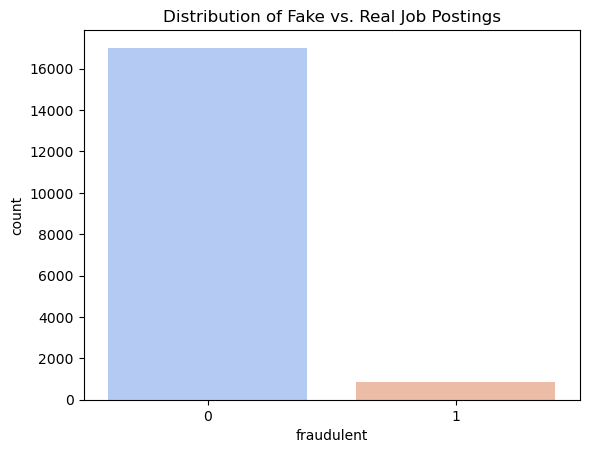

In [4]:
# Plot distribution of fraudulent jobs
sns.countplot(x=df["fraudulent"], palette="coolwarm")  
plt.title("Distribution of Fake vs. Real Job Postings")  
plt.show()

* Word Cloud for Fake Job Postings

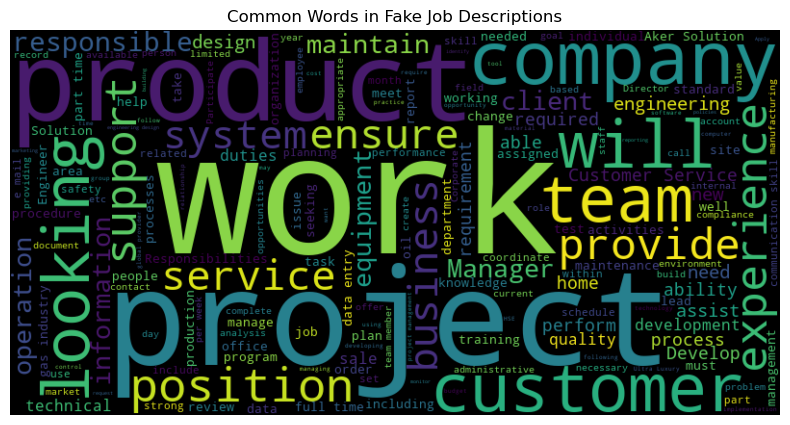

In [5]:
# Generate word cloud for fake job descriptions
fake_jobs = " ".join(df[df["fraudulent"] == 1]["description"])  
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(fake_jobs)  

plt.figure(figsize=(10,5))  
plt.imshow(wordcloud, interpolation="bilinear")  
plt.axis("off")  
plt.title("Common Words in Fake Job Descriptions")  
plt.show()

# Feature Engineering

* (1) TF-IDF Vectorization

In [6]:
# Ensure the same feature size is used as in training
vectorizer = TfidfVectorizer(max_features=5003, stop_words="english")  
X_tfidf = vectorizer.fit_transform(df["description"])  

# Save the trained vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")  

['tfidf_vectorizer.pkl']

* (2) Combine Features

In [7]:
from scipy.sparse import hstack  

X = hstack((X_tfidf, df[["telecommuting", "has_company_logo", "has_questions"]].values))  
y = df["fraudulent"]

#  Train Random Forest Model

* (1) Train-Test Split

In [8]:

# Ensure X and y are defined before splitting
if 'X' not in locals() or 'y' not in locals():
    raise ValueError("X and y must be defined before splitting the dataset.")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert sparse matrix to dense format before SMOTE (if using TfidfVectorizer or CountVectorizer)
if hasattr(X_train, "toarray"):
    X_train = X_train.toarray()

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy="auto", random_state=42)  # Auto balances classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new dataset size
print(f"✅ New training set size: {X_train_resampled.shape[0]} (Real: {sum(y_train_resampled == 0)}, Fake: {sum(y_train_resampled == 1)})")


✅ New training set size: 27222 (Real: 13611, Fake: 13611)


# Evaluation

🔄 Running RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
🔹 Tuned Accuracy: 0.9175055928411633

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96      3403
           1       0.35      0.83      0.49       173

    accuracy                           0.92      3576
   macro avg       0.67      0.87      0.72      3576
weighted avg       0.96      0.92      0.93      3576



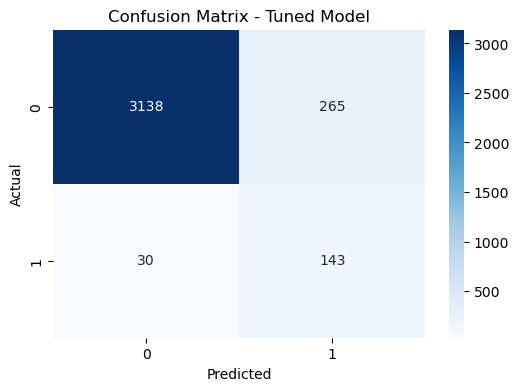

['best_rf_model.pkl']

In [15]:
# Define RandomForestClassifier with class weighting
rf = RandomForestClassifier(
    class_weight={0: 1, 1: 5},  # Adjust based on performance
    random_state=42,
    n_jobs=-1  # Enable parallel processing
)

# Reduced parameter grid for faster training
param_dist = {
    "n_estimators": [50, 100, 150],  
    "max_depth": [10, 20, None],  
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2]  
}

# Use a smaller subset of training data for tuning (20%)
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_resampled, y_train_resampled, train_size=0.2, random_state=42
)

# Run hyperparameter tuning
print("🔄 Running RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3, 
    verbose=1, n_jobs=-1, random_state=42
)
random_search.fit(X_train_sample, y_train_sample)
print("✅ Best Parameters Found:", random_search.best_params_)

# Use the best model
best_model = random_search.best_estimator_

# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust threshold for recall improvement
threshold = 0.35  
y_pred_adjusted = (y_probs > threshold).astype(int)

# Print performance metrics
print("🔹 Tuned Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_adjusted))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model if needed
joblib.dump(best_model, "best_rf_model.pkl")

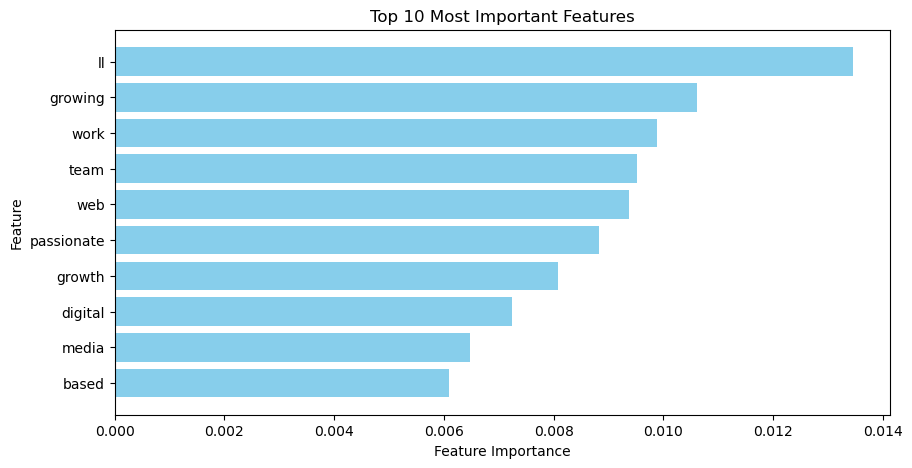

In [16]:
# Get feature importance from the best model
feature_importance = best_model.feature_importances_

# Get feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Ensure both arrays have the same length
min_length = min(len(feature_importance), len(feature_names))  # Take the shorter one

# Convert to DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names[:min_length],  # Ensure equal length
    'Importance': feature_importance[:min_length]  # Ensure equal length
})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot top features
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['Feature'][:10], feat_imp_df['Importance'][:10], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.show()

In [17]:
joblib.dump(best_model, "random_forest_model.pkl")

['random_forest_model.pkl']